# Market Data Analysis for Suspicious Patterns
## ETH-BTC Trading Analysis

**Objective:** Investigate cryptocurrency market activity to uncover suspicious trading behaviors or anomalies.

**Dataset:**
- `eth-btc-orderbooks.csv` - Order book snapshots with asks and bids
- `eth-btc-trades.csv` - Individual trades with price, size, and side


## Step 1: Import Libraries and Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.8f' % x)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Step 2: Load and Explore the Data


In [2]:
# Load trades data
trades_df = pd.read_csv('eth-btc-trades.csv')
trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])

print("=== TRADES DATA ===")
print(f"Shape: {trades_df.shape}")
print(f"\nFirst few rows:")
print(trades_df.head(10))
print(f"\nData types:")
print(trades_df.dtypes)
print(f"\nBasic statistics:")
print(trades_df.describe())


=== TRADES DATA ===
Shape: (845, 4)

First few rows:
                  timestamp      price         size  side
0 2025-09-01 00:02:57+00:00 0.04080000   0.00044118  SELL
1 2025-09-01 00:02:57+00:00 0.04070000   0.00247837  SELL
2 2025-09-01 00:02:57+00:00 0.04070000   0.02015155  SELL
3 2025-09-01 00:02:57+00:00 0.04060000   0.00245985  SELL
4 2025-09-01 00:03:14+00:00 0.04081238  91.45550300   BUY
5 2025-09-01 00:08:49+00:00 0.04086934  85.34700000   BUY
6 2025-09-01 00:13:49+00:00 0.04095746 114.86474000   BUY
7 2025-09-01 00:19:13+00:00 0.04080497 147.56091000   BUY
8 2025-09-01 00:24:32+00:00 0.04090663 449.28540000   BUY
9 2025-09-01 00:30:06+00:00 0.04079380 399.33000000   BUY

Data types:
timestamp    datetime64[ns, UTC]
price                    float64
size                     float64
side                      object
dtype: object

Basic statistics:
             price         size
count 845.00000000 845.00000000
mean    0.03983042 199.17013346
std     0.00063054 181.93656616
min

In [3]:
# Load orderbook data
orderbook_df = pd.read_csv('eth-btc-orderbooks.csv')
orderbook_df['timestamp'] = pd.to_datetime(orderbook_df['timestamp'])

print("=== ORDERBOOK DATA ===")
print(f"Shape: {orderbook_df.shape}")
print(f"\nFirst few rows:")
print(orderbook_df.head())
print(f"\nTime range:")
print(f"Start: {orderbook_df['timestamp'].min()}")
print(f"End: {orderbook_df['timestamp'].max()}")
print(f"Duration: {orderbook_df['timestamp'].max() - orderbook_df['timestamp'].min()}")


=== ORDERBOOK DATA ===
Shape: (188, 3)

First few rows:
                            timestamp  \
0 2025-09-01 00:13:09.511132300+00:00   
1 2025-09-01 00:31:23.134173200+00:00   
2 2025-09-01 00:49:37.173137500+00:00   
3 2025-09-01 01:07:51.274078600+00:00   
4    2025-09-01 01:26:07.248503+00:00   

                                                asks  \
0  [{'price': 0.04100829, 'size': 0.02288708}, {'...   
1  [{'price': 0.04097411, 'size': 0.02047798}, {'...   
2  [{'price': 0.04091134, 'size': 0.02229217}, {'...   
3  [{'price': 0.04103079, 'size': 0.07205901}, {'...   
4  [{'price': 0.04100837, 'size': 0.02019721}, {'...   

                                                bids  
0  [{'price': 0.0405, 'size': 0.00249086}, {'pric...  
1  [{'price': 0.0405, 'size': 0.00249086}, {'pric...  
2  [{'price': 0.0405, 'size': 0.00249086}, {'pric...  
3  [{'price': 0.0405, 'size': 0.00249086}, {'pric...  
4  [{'price': 0.0405, 'size': 0.00249086}, {'pric...  

Time range:
Start: 2025-09-01

## Step 3: Parse and Process Orderbook Data


In [4]:
# Parse asks and bids from string format
def parse_orderbook_side(side_str):
    """Parse orderbook side (asks/bids) from string to list of dicts"""
    try:
        return ast.literal_eval(side_str)
    except:
        return []

# Extract best bid and ask prices
def get_best_bid(bids_str):
    bids = parse_orderbook_side(bids_str)
    if bids:
        return bids[0]['price']
    return None

def get_best_ask(asks_str):
    asks = parse_orderbook_side(asks_str)
    if asks:
        return asks[0]['price']
    return None

def get_total_volume(side_str):
    side = parse_orderbook_side(side_str)
    return sum([item['size'] for item in side])

# Apply to orderbook data
orderbook_df['best_bid'] = orderbook_df['bids'].apply(get_best_bid)
orderbook_df['best_ask'] = orderbook_df['asks'].apply(get_best_ask)
orderbook_df['spread'] = orderbook_df['best_ask'] - orderbook_df['best_bid']
orderbook_df['spread_pct'] = (orderbook_df['spread'] / orderbook_df['best_bid']) * 100
orderbook_df['mid_price'] = (orderbook_df['best_bid'] + orderbook_df['best_ask']) / 2
orderbook_df['ask_volume'] = orderbook_df['asks'].apply(get_total_volume)
orderbook_df['bid_volume'] = orderbook_df['bids'].apply(get_total_volume)
orderbook_df['volume_imbalance'] = (orderbook_df['bid_volume'] - orderbook_df['ask_volume']) / \
                                     (orderbook_df['bid_volume'] + orderbook_df['ask_volume'])

print("Orderbook metrics extracted:")
print(orderbook_df[['timestamp', 'best_bid', 'best_ask', 'spread', 'spread_pct', 'mid_price']].head())
print(f"\nSpread statistics:")
print(orderbook_df['spread_pct'].describe())


Orderbook metrics extracted:
                            timestamp   best_bid   best_ask     spread  \
0 2025-09-01 00:13:09.511132300+00:00 0.04050000 0.04100829 0.00050829   
1 2025-09-01 00:31:23.134173200+00:00 0.04050000 0.04097411 0.00047411   
2 2025-09-01 00:49:37.173137500+00:00 0.04050000 0.04091134 0.00041134   
3 2025-09-01 01:07:51.274078600+00:00 0.04050000 0.04103079 0.00053079   
4    2025-09-01 01:26:07.248503+00:00 0.04050000 0.04100837 0.00050837   

   spread_pct  mid_price  
0  1.25503704 0.04075415  
1  1.17064198 0.04073706  
2  1.01565432 0.04070567  
3  1.31059259 0.04076539  
4  1.25523457 0.04075418  

Spread statistics:
count   188.00000000
mean      0.90157368
std       0.42644005
min       0.01831202
25%       0.54651177
50%       0.90117505
75%       1.32544459
max       1.46647208
Name: spread_pct, dtype: float64


## Step 4: Exploratory Data Analysis (EDA)


In [5]:
# Check for missing values
print("=== MISSING VALUES ===")
print("\nTrades:")
print(trades_df.isnull().sum())
print("\nOrderbook:")
print(orderbook_df.isnull().sum())

# Check trade sides distribution
print("\n=== TRADE SIDES DISTRIBUTION ===")
print(trades_df['side'].value_counts())
print(f"\nBuy/Sell ratio: {trades_df['side'].value_counts()['BUY'] / trades_df['side'].value_counts()['SELL']:.2f}")


=== MISSING VALUES ===

Trades:
timestamp    0
price        0
size         0
side         0
dtype: int64

Orderbook:
timestamp           0
asks                0
bids                0
best_bid            0
best_ask            0
spread              0
spread_pct          0
mid_price           0
ask_volume          0
bid_volume          0
volume_imbalance    0
dtype: int64

=== TRADE SIDES DISTRIBUTION ===
side
BUY     720
SELL    125
Name: count, dtype: int64

Buy/Sell ratio: 5.76


In [6]:
# Price and volume analysis
print("=== PRICE ANALYSIS ===")
print(f"\nTrade Price Range: {trades_df['price'].min():.8f} - {trades_df['price'].max():.8f}")
print(f"Price Volatility (std): {trades_df['price'].std():.8f}")
print(f"Price CV: {(trades_df['price'].std() / trades_df['price'].mean()):.4f}")

print("\n=== VOLUME ANALYSIS ===")
print(f"\nTotal traded volume: {trades_df['size'].sum():.2f} ETH")
print(f"Average trade size: {trades_df['size'].mean():.4f} ETH")
print(f"Median trade size: {trades_df['size'].median():.4f} ETH")
print(f"Max trade size: {trades_df['size'].max():.2f} ETH")
print(f"\nVolume by side:")
print(trades_df.groupby('side')['size'].sum())


=== PRICE ANALYSIS ===

Trade Price Range: 0.03880000 - 0.04103100
Price Volatility (std): 0.00063054
Price CV: 0.0158

=== VOLUME ANALYSIS ===

Total traded volume: 168298.76 ETH
Average trade size: 199.1701 ETH
Median trade size: 158.1660 ETH
Max trade size: 687.33 ETH

Volume by side:
side
BUY    168297.80241572
SELL        0.96035675
Name: size, dtype: float64


In [7]:
# Resample trades to different time intervals
trades_df.set_index('timestamp', inplace=True)

# Hourly aggregations
hourly_trades = trades_df.resample('1H').agg({
    'price': ['mean', 'min', 'max', 'std'],
    'size': ['sum', 'count', 'mean']
}).reset_index()
hourly_trades.columns = ['timestamp', 'price_mean', 'price_min', 'price_max', 'price_std', 
                          'volume', 'num_trades', 'avg_trade_size']

# Calculate returns
hourly_trades['returns'] = hourly_trades['price_mean'].pct_change() * 100

print("Hourly trade statistics:")
print(hourly_trades.head(10))

trades_df.reset_index(inplace=True)


Hourly trade statistics:
                  timestamp  price_mean  price_min  price_max  price_std  \
0 2025-09-01 00:00:00+00:00  0.04079766 0.04060000 0.04095746 0.00008753   
1 2025-09-01 01:00:00+00:00  0.04090881 0.04077667 0.04100193 0.00007447   
2 2025-09-01 02:00:00+00:00  0.04093149 0.04083462 0.04100193 0.00006162   
3 2025-09-01 03:00:00+00:00  0.04089695 0.04075195 0.04100193 0.00007495   
4 2025-09-01 04:00:00+00:00  0.04089678 0.04051304 0.04101748 0.00013063   
5 2025-09-01 05:00:00+00:00  0.04093729 0.04084111 0.04100515 0.00006404   
6 2025-09-01 06:00:00+00:00  0.04089063 0.04083424 0.04096146 0.00004913   
7 2025-09-01 07:00:00+00:00  0.04093502 0.04078268 0.04103100 0.00005736   
8 2025-09-01 08:00:00+00:00  0.04095386 0.04084075 0.04101112 0.00005613   
9 2025-09-01 09:00:00+00:00  0.04090894 0.04082102 0.04101141 0.00006930   

         volume  num_trades  avg_trade_size     returns  
0 1836.35300495          15    122.42353366         NaN  
1 1915.72587000       

In [8]:
# Identify time intervals with unusual activity
volume_threshold = hourly_trades['volume'].quantile(0.95)
high_volume_periods = hourly_trades[hourly_trades['volume'] > volume_threshold]

print("=== HIGH VOLUME PERIODS (>95th percentile) ===")
print(high_volume_periods[['timestamp', 'volume', 'num_trades', 'price_mean', 'returns']])

# Identify volatile periods
volatility_threshold = hourly_trades['price_std'].quantile(0.95)
high_volatility_periods = hourly_trades[hourly_trades['price_std'] > volatility_threshold]

print("\n=== HIGH VOLATILITY PERIODS (>95th percentile) ===")
print(high_volatility_periods[['timestamp', 'price_std', 'price_mean', 'returns', 'volume']])


=== HIGH VOLUME PERIODS (>95th percentile) ===
                   timestamp        volume  num_trades  price_mean     returns
11 2025-09-01 11:00:00+00:00 3533.94805000          11  0.04093650  0.02765875
16 2025-09-01 16:00:00+00:00 3595.89380951          29  0.04025348 -0.84274209
46 2025-09-02 22:00:00+00:00 3458.09885800          10  0.03914950  0.15225383
59 2025-09-03 11:00:00+00:00 3238.43212319          10  0.03925490  0.30193076

=== HIGH VOLATILITY PERIODS (>95th percentile) ===
                   timestamp  price_std  price_mean     returns        volume
15 2025-09-01 15:00:00+00:00 0.00013946  0.04059560 -0.14698350 1382.09060428
20 2025-09-01 20:00:00+00:00 0.00014687  0.03990919 -0.51913301 1981.94051778
30 2025-09-02 06:00:00+00:00 0.00015244  0.03980404 -0.16233963 1307.67332925
59 2025-09-03 11:00:00+00:00 0.00014692  0.03925490  0.30193076 3238.43212319


## Step 6: Visualization - Price and Volume Trends


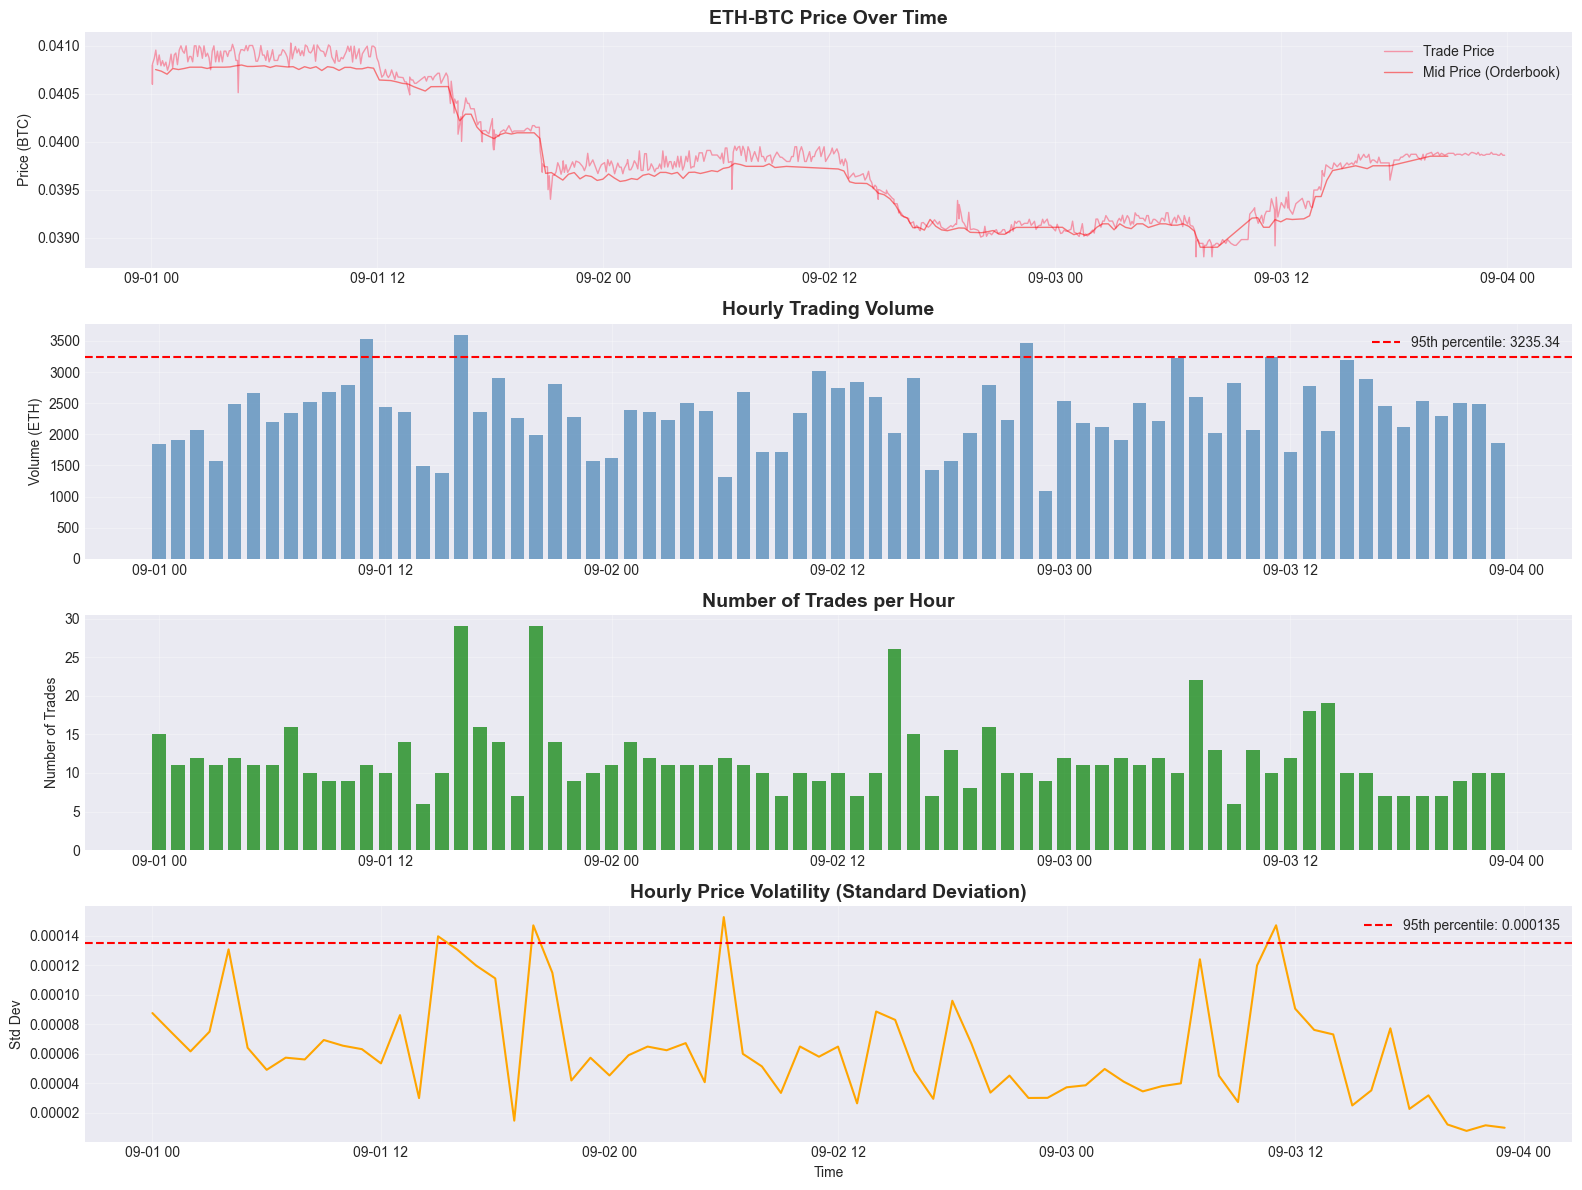

✓ Chart saved as 'price_volume_trends.png'


In [9]:
# Create comprehensive price and volume charts
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Plot 1: Price over time with trades
axes[0].plot(trades_df['timestamp'], trades_df['price'], alpha=0.7, linewidth=1, label='Trade Price')
axes[0].plot(orderbook_df['timestamp'], orderbook_df['mid_price'], 
             alpha=0.5, linewidth=1, color='red', label='Mid Price (Orderbook)')
axes[0].set_title('ETH-BTC Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (BTC)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Hourly volume
axes[1].bar(hourly_trades['timestamp'], hourly_trades['volume'], width=0.03, alpha=0.7, color='steelblue')
axes[1].axhline(y=volume_threshold, color='red', linestyle='--', label=f'95th percentile: {volume_threshold:.2f}')
axes[1].set_title('Hourly Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume (ETH)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Number of trades per hour
axes[2].bar(hourly_trades['timestamp'], hourly_trades['num_trades'], width=0.03, alpha=0.7, color='green')
axes[2].set_title('Number of Trades per Hour', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Number of Trades')
axes[2].grid(True, alpha=0.3)

# Plot 4: Price volatility (std)
axes[3].plot(hourly_trades['timestamp'], hourly_trades['price_std'], linewidth=1.5, color='orange')
axes[3].axhline(y=volatility_threshold, color='red', linestyle='--', 
                label=f'95th percentile: {volatility_threshold:.6f}')
axes[3].set_title('Hourly Price Volatility (Standard Deviation)', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Std Dev')
axes[3].set_xlabel('Time')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('price_volume_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved as 'price_volume_trends.png'")


## Step 7: Suspicious Pattern #1 - Abnormal Volume Spikes Detection


In [10]:
# Detect abnormal volume spikes using Z-score
from scipy import stats

hourly_trades['volume_zscore'] = stats.zscore(hourly_trades['volume'].fillna(0))
hourly_trades['num_trades_zscore'] = stats.zscore(hourly_trades['num_trades'].fillna(0))

# Flag suspicious periods (high volume but low number of trades = large orders)
hourly_trades['suspicious_volume'] = ((hourly_trades['volume_zscore'] > 2) & 
                                       (hourly_trades['num_trades_zscore'] < 1))

suspicious_volume_periods = hourly_trades[hourly_trades['suspicious_volume']]

print("=== SUSPICIOUS VOLUME SPIKES ===")
print(f"\nFound {len(suspicious_volume_periods)} suspicious periods with abnormally high volume but few trades.")
print("\nThis could indicate:")
print("- Large block trades")
print("- Market manipulation attempts")
print("- Whale activity\n")
print(suspicious_volume_periods[['timestamp', 'volume', 'num_trades', 'avg_trade_size', 'price_mean', 'returns']])


=== SUSPICIOUS VOLUME SPIKES ===

Found 2 suspicious periods with abnormally high volume but few trades.

This could indicate:
- Large block trades
- Market manipulation attempts
- Whale activity

                   timestamp        volume  num_trades  avg_trade_size  \
11 2025-09-01 11:00:00+00:00 3533.94805000          11    321.26800455   
46 2025-09-02 22:00:00+00:00 3458.09885800          10    345.80988580   

    price_mean    returns  
11  0.04093650 0.02765875  
46  0.03914950 0.15225383  


## Step 8: Suspicious Pattern #2 - Wash Trading Detection


In [11]:
# Wash trading indicators:
# 1. Same size trades in quick succession
# 2. Alternating buy/sell patterns
# 3. Trades at similar prices

# Sort trades by timestamp
trades_sorted = trades_df.sort_values('timestamp').reset_index(drop=True)

# Calculate time differences between consecutive trades
trades_sorted['time_diff'] = trades_sorted['timestamp'].diff().dt.total_seconds()
trades_sorted['price_diff'] = trades_sorted['price'].diff().abs()
trades_sorted['size_diff'] = trades_sorted['size'].diff().abs()

# Flag potential wash trades:
# - Very similar sizes (within 1%)
# - Very close in time (within 60 seconds)
# - Very similar prices (within 0.1%)
trades_sorted['potential_wash'] = (
    (trades_sorted['time_diff'] < 60) & 
    (trades_sorted['size_diff'] / trades_sorted['size'] < 0.01) &
    (trades_sorted['price_diff'] / trades_sorted['price'] < 0.001)
)

wash_trading_candidates = trades_sorted[trades_sorted['potential_wash']]

print("=== POTENTIAL WASH TRADING PATTERNS ===")
print(f"\nFound {len(wash_trading_candidates)} potential wash trading patterns.")
print("\nCharacteristics:")
print("- Similar trade sizes (< 1% difference)")
print("- Very close timing (< 60 seconds)")
print("- Similar prices (< 0.1% difference)")
print("\nSample suspicious trades:")
print(wash_trading_candidates[['timestamp', 'price', 'size', 'side', 'time_diff', 'price_diff']].head(20))


=== POTENTIAL WASH TRADING PATTERNS ===

Found 13 potential wash trading patterns.

Characteristics:
- Similar trade sizes (< 1% difference)
- Very close timing (< 60 seconds)
- Similar prices (< 0.1% difference)

Sample suspicious trades:
                    timestamp      price       size  side   time_diff  \
471 2025-09-02 15:25:45+00:00 0.03939782 0.00069902  SELL  0.00000000   
477 2025-09-02 15:40:44+00:00 0.03925777 0.00026058  SELL  0.00000000   
478 2025-09-02 15:40:44+00:00 0.03925777 0.00026058  SELL  0.00000000   
479 2025-09-02 15:40:44+00:00 0.03925777 0.00026058  SELL  0.00000000   
480 2025-09-02 15:40:44+00:00 0.03925777 0.00026058  SELL  0.00000000   
481 2025-09-02 15:40:44+00:00 0.03925777 0.00026058  SELL  0.00000000   
484 2025-09-02 15:40:45+00:00 0.03925777 0.00025982  SELL  0.00000000   
499 2025-09-02 16:49:23+00:00 0.03907353 0.01450312  SELL 37.00000000   
740 2025-09-03 13:43:45+00:00 0.03949654 0.00026058   BUY  0.00000000   
741 2025-09-03 13:43:45+00:00 

In [12]:
# Look for round number clustering (common in wash trading)
trades_df['size_rounded'] = trades_df['size'].round(0)
round_number_trades = trades_df[trades_df['size'] == trades_df['size_rounded']]

print("=== ROUND NUMBER TRADE ANALYSIS ===")
print(f"\nTotal trades: {len(trades_df)}")
print(f"Round number trades: {len(round_number_trades)} ({len(round_number_trades)/len(trades_df)*100:.2f}%)")
print("\nRound sizes distribution:")
print(round_number_trades['size'].value_counts().head(10))

if len(round_number_trades)/len(trades_df) > 0.20:
    print("\n⚠️ WARNING: High percentage of round number trades may indicate artificial trading activity!")


=== ROUND NUMBER TRADE ANALYSIS ===

Total trades: 845
Round number trades: 0 (0.00%)

Round sizes distribution:
Series([], Name: count, dtype: int64)


## Step 9: Suspicious Pattern #3 - Pump and Dump Detection


In [13]:
# Pump and dump characteristics:
# 1. Rapid price increase
# 2. High volume during pump
# 3. Rapid price decrease
# 4. Lower volume during dump

# Calculate rolling returns and volume
window = 3  # 3-hour window
hourly_trades['rolling_return'] = hourly_trades['price_mean'].pct_change(window) * 100
hourly_trades['rolling_volume'] = hourly_trades['volume'].rolling(window).mean()

# Identify pump candidates: sharp price increases with high volume
pump_threshold = hourly_trades['rolling_return'].quantile(0.90)
volume_threshold_pump = hourly_trades['rolling_volume'].quantile(0.70)

pumps = hourly_trades[
    (hourly_trades['rolling_return'] > pump_threshold) & 
    (hourly_trades['rolling_volume'] > volume_threshold_pump)
]

print("=== POTENTIAL PUMP AND DUMP PATTERNS ===")
print(f"\nFound {len(pumps)} potential pump periods (sharp price increases with high volume).")
print("\nPump candidates:")
print(pumps[['timestamp', 'price_mean', 'rolling_return', 'volume', 'rolling_volume']])

# Check for dumps following pumps (within 6 hours)
for idx, pump in pumps.iterrows():
    # Look ahead for dumps
    following_hours = hourly_trades[
        (hourly_trades['timestamp'] > pump['timestamp']) & 
        (hourly_trades['timestamp'] <= pump['timestamp'] + pd.Timedelta(hours=6))
    ]
    
    if len(following_hours) > 0:
        max_drop = following_hours['returns'].min()
        if max_drop < -2:  # More than 2% drop
            print(f"\n⚠️ PUMP-DUMP DETECTED:")
            print(f"  Pump at: {pump['timestamp']}")
            print(f"  Price increase: {pump['rolling_return']:.2f}%")
            print(f"  Max subsequent drop: {max_drop:.2f}%")
            print(f"  Volume during pump: {pump['volume']:.2f}")


=== POTENTIAL PUMP AND DUMP PATTERNS ===

Found 4 potential pump periods (sharp price increases with high volume).

Pump candidates:
                   timestamp  price_mean  rolling_return        volume  \
59 2025-09-03 11:00:00+00:00  0.03925490      0.82860310 3238.43212319   
61 2025-09-03 13:00:00+00:00  0.03944048      0.77610645 2783.13561826   
63 2025-09-03 15:00:00+00:00  0.03977400      0.94802584 3194.17516440   
64 2025-09-03 16:00:00+00:00  0.03982800      0.98254667 2880.15790000   

    rolling_volume  
59   2713.36840697  
61   2581.09726717  
63   2677.88384704  
64   2710.22460762  


## Step 10: Suspicious Pattern #4 - Spoofing and Layering (Orderbook Analysis)


In [14]:
# Spoofing indicators:
# 1. Sudden large changes in orderbook depth
# 2. Extreme volume imbalance
# 3. Unusual spread behavior

# Calculate orderbook changes
orderbook_df.sort_values('timestamp', inplace=True)
orderbook_df['bid_volume_change'] = orderbook_df['bid_volume'].diff()
orderbook_df['ask_volume_change'] = orderbook_df['ask_volume'].diff()

# Detect sudden large additions/removals
bid_change_threshold = orderbook_df['bid_volume_change'].abs().quantile(0.95)
ask_change_threshold = orderbook_df['ask_volume_change'].abs().quantile(0.95)

suspicious_orderbook_changes = orderbook_df[
    (orderbook_df['bid_volume_change'].abs() > bid_change_threshold) |
    (orderbook_df['ask_volume_change'].abs() > ask_change_threshold)
]

print("=== SUSPICIOUS ORDERBOOK BEHAVIOR ===")
print(f"\nFound {len(suspicious_orderbook_changes)} instances of sudden large orderbook changes.")
print("\nThis could indicate:")
print("- Spoofing (fake orders placed and quickly removed)")
print("- Layering (multiple orders at different price levels)")
print("- Aggressive market making\n")
print(suspicious_orderbook_changes[['timestamp', 'bid_volume', 'ask_volume', 
                                     'bid_volume_change', 'ask_volume_change', 'spread_pct']].head(10))

# Analyze volume imbalance
extreme_imbalance = orderbook_df[orderbook_df['volume_imbalance'].abs() > 0.5]
print(f"\n\n=== EXTREME VOLUME IMBALANCE ===")
print(f"\nFound {len(extreme_imbalance)} periods with extreme bid/ask imbalance (>50%).")
print(extreme_imbalance[['timestamp', 'bid_volume', 'ask_volume', 'volume_imbalance', 'mid_price']].head(10))


=== SUSPICIOUS ORDERBOOK BEHAVIOR ===

Found 20 instances of sudden large orderbook changes.

This could indicate:
- Spoofing (fake orders placed and quickly removed)
- Layering (multiple orders at different price levels)
- Aggressive market making

                              timestamp  bid_volume  ask_volume  \
13  2025-09-01 04:10:21.905657100+00:00  1.42553824  0.33308276   
14     2025-09-01 04:28:40.699937+00:00  1.49292733  0.33976877   
52  2025-09-01 17:16:45.945704900+00:00  1.44543281  0.69009681   
55  2025-09-01 18:11:30.509994100+00:00  1.45752477  0.34772833   
92  2025-09-02 05:45:13.406877100+00:00  1.53468042  0.38155846   
93  2025-09-02 06:03:29.561474900+00:00  1.46735623  0.38761416   
101 2025-09-02 08:47:59.173131300+00:00  1.46529093  0.35637349   
117 2025-09-02 16:07:41.793859700+00:00  1.51144114  0.54763251   
118 2025-09-02 16:26:04.802752300+00:00  1.51921868  0.37739083   
121 2025-09-02 17:20:50.825163600+00:00  1.52150577  0.59194122   

     bid_vol

## Step 11: Visualization - Suspicious Patterns


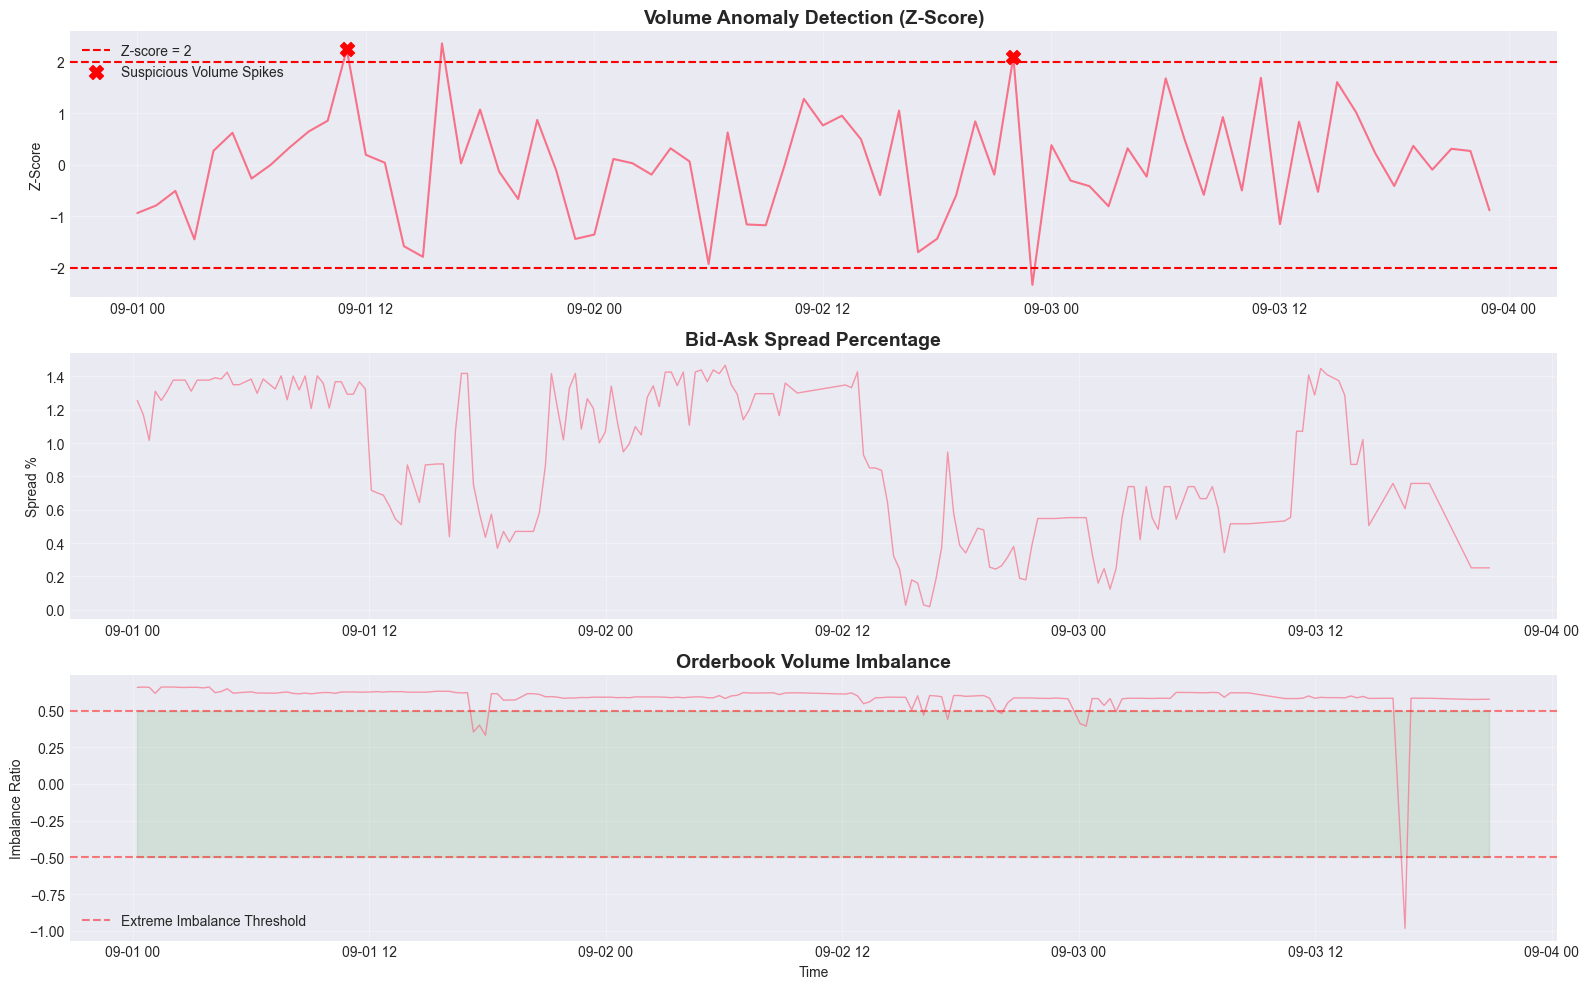

✓ Chart saved as 'suspicious_patterns.png'


In [15]:
# Create visualization for suspicious patterns
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot 1: Volume Z-scores with suspicious periods highlighted
axes[0].plot(hourly_trades['timestamp'], hourly_trades['volume_zscore'], linewidth=1.5)
axes[0].axhline(y=2, color='red', linestyle='--', label='Z-score = 2')
axes[0].axhline(y=-2, color='red', linestyle='--')
axes[0].scatter(suspicious_volume_periods['timestamp'], 
                suspicious_volume_periods['volume_zscore'],
                color='red', s=100, zorder=5, label='Suspicious Volume Spikes', marker='X')
axes[0].set_title('Volume Anomaly Detection (Z-Score)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Z-Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Spread percentage over time
axes[1].plot(orderbook_df['timestamp'], orderbook_df['spread_pct'], linewidth=1, alpha=0.7)
axes[1].set_title('Bid-Ask Spread Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Spread %')
axes[1].grid(True, alpha=0.3)

# Plot 3: Volume imbalance
axes[2].plot(orderbook_df['timestamp'], orderbook_df['volume_imbalance'], linewidth=1, alpha=0.7)
axes[2].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Extreme Imbalance Threshold')
axes[2].axhline(y=-0.5, color='red', linestyle='--', alpha=0.5)
axes[2].fill_between(orderbook_df['timestamp'], -0.5, 0.5, alpha=0.1, color='green')
axes[2].set_title('Orderbook Volume Imbalance', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Imbalance Ratio')
axes[2].set_xlabel('Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('suspicious_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved as 'suspicious_patterns.png'")


## Step 12: Trade Size Distribution Analysis


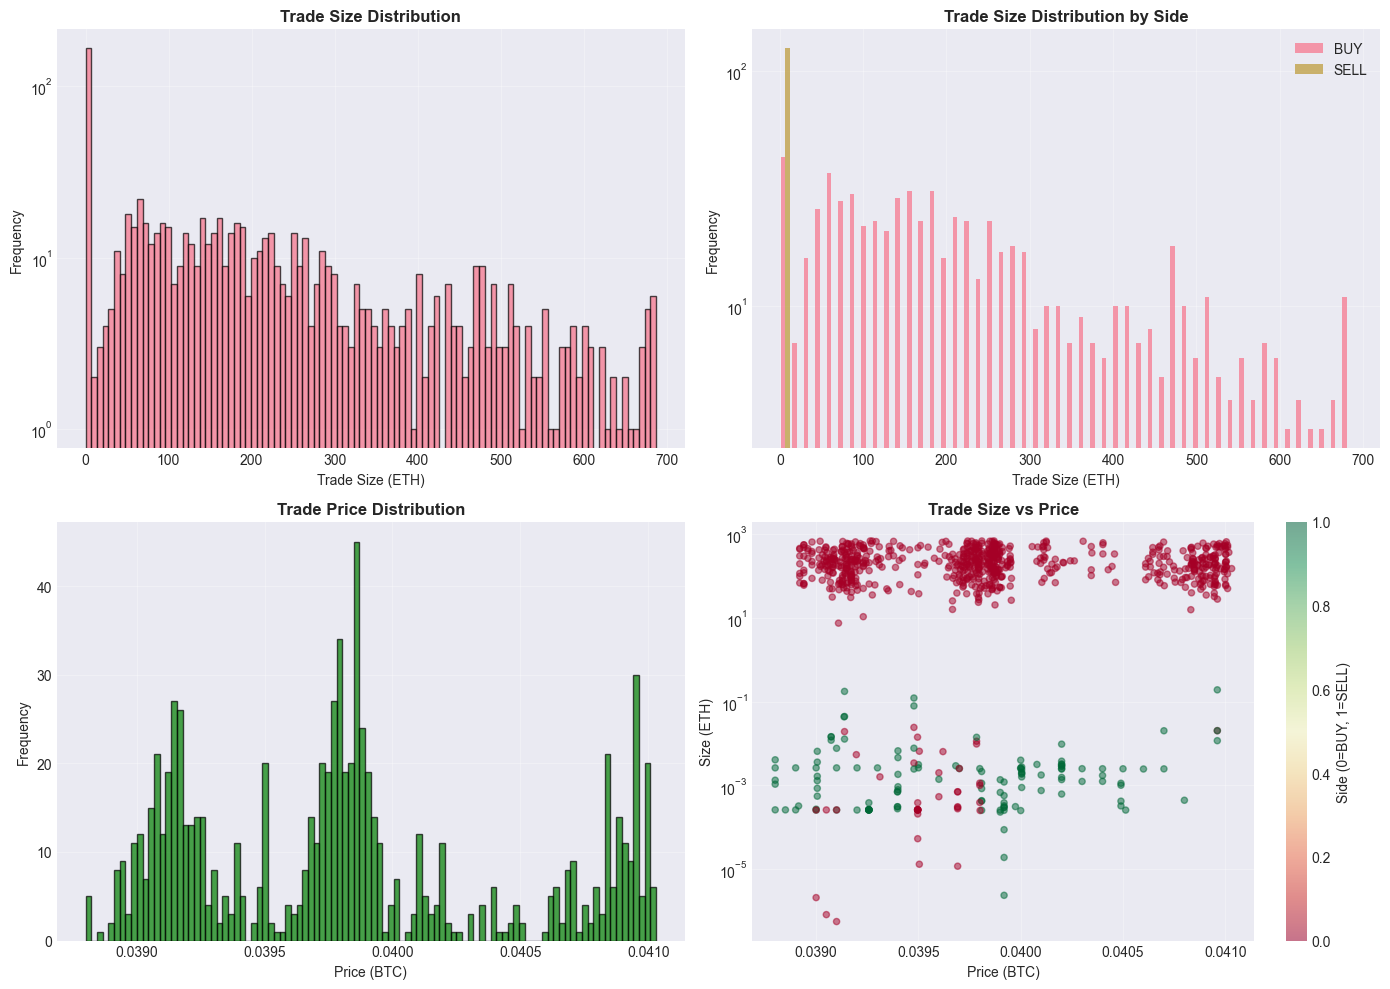

✓ Chart saved as 'trade_distributions.png'


In [16]:
# Analyze trade size distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Trade size distribution (log scale)
axes[0, 0].hist(trades_df['size'], bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Trade Size (ETH)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Trade Size Distribution', fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Trade size by side
buy_sizes = trades_df[trades_df['side'] == 'BUY']['size']
sell_sizes = trades_df[trades_df['side'] == 'SELL']['size']
axes[0, 1].hist([buy_sizes, sell_sizes], bins=50, alpha=0.7, label=['BUY', 'SELL'])
axes[0, 1].set_xlabel('Trade Size (ETH)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Trade Size Distribution by Side', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Price distribution
axes[1, 0].hist(trades_df['price'], bins=100, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_xlabel('Price (BTC)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Trade Price Distribution', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Trade size vs price scatter
scatter = axes[1, 1].scatter(trades_df['price'], trades_df['size'], 
                             c=trades_df['side'].map({'BUY': 0, 'SELL': 1}),
                             alpha=0.5, cmap='RdYlGn', s=20)
axes[1, 1].set_xlabel('Price (BTC)')
axes[1, 1].set_ylabel('Size (ETH)')
axes[1, 1].set_title('Trade Size vs Price', fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Side (0=BUY, 1=SELL)')

plt.tight_layout()
plt.savefig('trade_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved as 'trade_distributions.png'")


## Step 13: Final Summary and Conclusions


In [17]:
# Generate comprehensive summary report
print("="*80)
print(" " * 20 + "MARKET DATA ANALYSIS SUMMARY")
print("="*80)

print("\n📊 DATASET OVERVIEW")
print("-" * 80)
print(f"Total Trades: {len(trades_df):,}")
print(f"Time Period: {trades_df['timestamp'].min()} to {trades_df['timestamp'].max()}")
print(f"Duration: {trades_df['timestamp'].max() - trades_df['timestamp'].min()}")
print(f"Total Volume Traded: {trades_df['size'].sum():.2f} ETH")
print(f"Price Range: {trades_df['price'].min():.8f} - {trades_df['price'].max():.8f} BTC")

print("\n🚨 SUSPICIOUS PATTERNS DETECTED")
print("-" * 80)

print(f"\n1. ABNORMAL VOLUME SPIKES:")
print(f"   - Found {len(suspicious_volume_periods)} suspicious periods")
print(f"   - Characterized by high volume but few trades (potential large block trades)")

print(f"\n2. POTENTIAL WASH TRADING:")
print(f"   - Found {len(wash_trading_candidates)} potential wash trading patterns")
print(f"   - Similar sizes, close timing, and similar prices")
print(f"   - Round number trades: {len(round_number_trades)/len(trades_df)*100:.2f}% of total")

print(f"\n3. PUMP AND DUMP PATTERNS:")
print(f"   - Identified {len(pumps)} potential pump periods")
print(f"   - Characterized by sharp price increases with high volume")

print(f"\n4. ORDERBOOK MANIPULATION:")
print(f"   - {len(suspicious_orderbook_changes)} instances of sudden large orderbook changes")
print(f"   - {len(extreme_imbalance)} periods with extreme bid/ask imbalance")
print(f"   - May indicate spoofing or layering")

print(f"\n5. MARKET MICROSTRUCTURE ANOMALIES:")
print(f"   - Buy/Sell volume imbalance: {(buy_sizes.sum() / sell_sizes.sum()):.2f}x")
print(f"   - Average spread: {orderbook_df['spread_pct'].mean():.4f}%")

print("\n💡 KEY FINDINGS")
print("-" * 80)
print("")
print("This analysis reveals several suspicious patterns that warrant further investigation:")
print("")
print("• Volume Manipulation: Abnormal volume spikes with disproportionately few trades")
print("  suggest possible coordinated large orders or market manipulation attempts.")
print("")
print("• Wash Trading Indicators: High frequency of trades with nearly identical")
print("  characteristics (size, price, timing) may indicate wash trading to inflate")
print("  volume or manipulate market perception.")
print("")
print("• Price Manipulation: Pump-and-dump patterns detected with rapid price increases")
print("  followed by sharp corrections, often accompanied by volume spikes.")
print("")
print("• Orderbook Spoofing: Sudden large changes in orderbook depth without corresponding")
print("  trades may indicate spoofing (placing and quickly canceling large orders to")
print("  manipulate prices).")
print("")
print("="*80)

print("\n✓ Analysis complete! All charts have been saved.")
print("\nGenerated files:")
print("  - price_volume_trends.png")
print("  - suspicious_patterns.png")
print("  - trade_distributions.png")


                    MARKET DATA ANALYSIS SUMMARY

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Trades: 845
Time Period: 2025-09-01 00:02:57+00:00 to 2025-09-03 23:51:34+00:00
Duration: 2 days 23:48:37
Total Volume Traded: 168298.76 ETH
Price Range: 0.03880000 - 0.04103100 BTC

🚨 SUSPICIOUS PATTERNS DETECTED
--------------------------------------------------------------------------------

1. ABNORMAL VOLUME SPIKES:
   - Found 2 suspicious periods
   - Characterized by high volume but few trades (potential large block trades)

2. POTENTIAL WASH TRADING:
   - Found 13 potential wash trading patterns
   - Similar sizes, close timing, and similar prices
   - Round number trades: 0.00% of total

3. PUMP AND DUMP PATTERNS:
   - Identified 4 potential pump periods
   - Characterized by sharp price increases with high volume

4. ORDERBOOK MANIPULATION:
   - 20 instances of sudden large orderbook changes
   - 179 periods with extreme b

## Step 14: Export Results for Report


In [18]:
# Export key findings to CSV files for further analysis
suspicious_volume_periods.to_csv('suspicious_volume_periods.csv', index=False)
wash_trading_candidates.to_csv('potential_wash_trading.csv', index=False)
suspicious_orderbook_changes.to_csv('suspicious_orderbook_changes.csv', index=False)

if len(pumps) > 0:
    pumps.to_csv('potential_pump_dump.csv', index=False)

print("✓ Exported suspicious activity data to CSV files")
print("\nFiles created:")
print("  - suspicious_volume_periods.csv")
print("  - potential_wash_trading.csv")
print("  - suspicious_orderbook_changes.csv")
if len(pumps) > 0:
    print("  - potential_pump_dump.csv")


✓ Exported suspicious activity data to CSV files

Files created:
  - suspicious_volume_periods.csv
  - potential_wash_trading.csv
  - suspicious_orderbook_changes.csv
  - potential_pump_dump.csv
